<a href="https://colab.research.google.com/github/cainabranco/AndroidOOPSenai/blob/master/final_eda_tcc_gustavo_cain_branco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

Etapa 1 - Definindo Funções

Carregamento dos dados

In [ ]:
def carregar_dados_anos(anos):
    """
    Carrega os dados dos anos especificados e retorna um DataFrame concatenado.

    Parâmetros:
        anos (list): Lista de anos para carregar os dados.
        caminho_base (str): Caminho base para os arquivos CSV, sem a parte específica do ano.

    Retorna:
        pd.DataFrame: DataFrame concatenado com os dados dos anos especificados.
    """
    # Carregar dados dos anos especificados
    inmet_dfs = map(lambda ano: pd.read_csv(f'/content/drive/MyDrive/TCC 2024/INMET_S_SC_A806_FLORIANOPOLIS_01-01-{ano}_A_31-12-{ano}.CSV', encoding='latin1', delimiter=';', skiprows=8), anos)

    # Concatenar os DataFrames em um único DataFrame
    inmet_df = pd.concat(list(inmet_dfs), ignore_index=True)

    return inmet_df


Transformação de Dados

In [ ]:
import pandas as pd
from datetime import datetime

def transformar_dados_climaticos(df):
    """
    Aplica diversas transformações aos dados climáticos de um DataFrame.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados climáticos.

    Retorna:
        pd.DataFrame: DataFrame transformado.
    """
    # Converter a coluna 'Data' para datetime
    df['Data'] = pd.to_datetime(df['Data'])

    # Função para converter hora UTC para formato de 24 horas
    def converter_hora_24h(hora_utc):
        hora_utc = hora_utc.replace(' UTC', '')
        hora_datetime = datetime.strptime(hora_utc, "%H%M")
        return int(hora_datetime.strftime("%H"))

    # Aplicar a função à coluna 'Hora UTC'
    df['Hora UTC'] = df['Hora UTC'].apply(converter_hora_24h)

    # Converter colunas de string para float onde aplicável
    df = df.apply(lambda x: x.str.replace(',', '.').astype(float) if x.dtype == 'object' else x)

    # Renomear colunas
    novos_nomes = {
        'Data': 'date',
        'Hora UTC': 'hour',
        'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'max_temp',
        'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'min_temp'
    }
    df = df.rename(columns=novos_nomes)

    # Manter apenas as colunas de interesse
    df = df[list(novos_nomes.values())]

    # Extrair características temporais
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day

    # Calcular a temperatura média horária
    df['mean_temp'] = (df['max_temp'] + df['min_temp']) / 2

    return df


Etapa 2 - Aplicação:
2021 a 2023

In [ ]:
anos = [2021, 2022, 2023]
inmet_df = carregar_dados_anos(anos)
inmet_df = transformar_dados_climaticos(inmet_df)

In [ ]:
inmet_df.describe()

,date,hour,max_temp,min_temp,year,month,day,mean_temp
count,26280,26280.000000,26237.000000,26237.000000,26280.000000,26280.000000,26280.000000,26237.000000
mean,2022-07-02 00:00:00,11.500000,21.616755,20.690407,2022.000000,6.526027,15.720548,21.153581
min,2021-01-01 00:00:00,0.000000,4.600000,4.000000,2021.000000,1.000000,1.000000,4.300000
25%,2021-10-01 00:00:00,5.750000,18.600000,17.900000,2021.000000,4.000000,8.000000,18.250000
50%,2022-07-02 00:00:00,11.500000,21.600000,20.700000,2022.000000,7.000000,16.000000,21.150000
75%,2023-04-02 00:00:00,17.250000,24.600000,23.600000,2023.000000,10.000000,23.000000,24.100000
max,2023-12-31 00:00:00,23.000000,37.000000,35.600000,2023.000000,12.000000,31.000000,36.300000
std,NaN,6.922318,4.345618,4.227519,0.816512,3.447917,8.796414,4.272331


Contagem de Nulos

In [ ]:
# Contar o número de entradas NaN
nan_count = inmet_df.isnull().sum()

# Selecionar linhas com NaN
nan_rows = inmet_df[inmet_df.isnull().any(axis=1)]

# Exibir resultados
print("Número de entradas NaN:")
print(nan_count)

print("\nLinhas com NaN:")
print(nan_rows)

Número de entradas NaN:
date          0
hour          0
max_temp     43
min_temp     43
year          0
month         0
day           0
mean_temp    43
dtype: int64

Linhas com NaN:
            date  hour  max_temp  min_temp  year  month  day  mean_temp
3919  2021-06-13     7       NaN       NaN  2021      6   13        NaN
4287  2021-06-28    15       NaN       NaN  2021      6   28        NaN
5015  2021-07-28    23       NaN       NaN  2021      7   28        NaN
5027  2021-07-29    11       NaN       NaN  2021      7   29        NaN
5040  2021-07-30     0       NaN       NaN  2021      7   30        NaN
5075  2021-07-31    11       NaN       NaN  2021      7   31        NaN
5076  2021-07-31    12       NaN       NaN  2021      7   31        NaN
13113 2022-07-01     9       NaN       NaN  2022      7    1        NaN
14957 2022-09-16     5       NaN       NaN  2022      9   16        NaN
17513 2022-12-31    17       NaN       NaN  2022     12   31        NaN
17514 2022-12-31    18    

Contagem Diária

In [ ]:
nan_rows_by_day = nan_rows.groupby('date').agg(count=('hour', 'count'))
print(nan_rows_by_day)

            count
date             
2021-06-13      1
2021-06-28      1
2021-07-28      1
2021-07-29      1
2021-07-30      1
2021-07-31      2
2022-07-01      1
2022-09-16      1
2022-12-31      7
2023-05-15      1
2023-06-08      1
2023-08-14      1
2023-08-20      1
2023-09-27     16
2023-09-28      7


Remoção de Valores Nulos

In [ ]:
inmet_df = inmet_df.dropna(subset=['mean_temp'])

Etapa 3 - Modelagem

# V1 - Granularidade Horária
Dados de 2021 a 2023


In [ ]:
# Criando o conjunto de dados final com as médias
X = inmet_df[['year', 'month']]
y = inmet_df['mean_temp']

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurando o modelo de regressão com florestas aleatórias
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

Avaliação do modelo

In [ ]:
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Avaliando o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

Mean Absolute Error: 2.3567159368008146
Root Mean Squared Error: 3.0007120314247886
R^2 Score: 0.5124941112141239


Print da V1

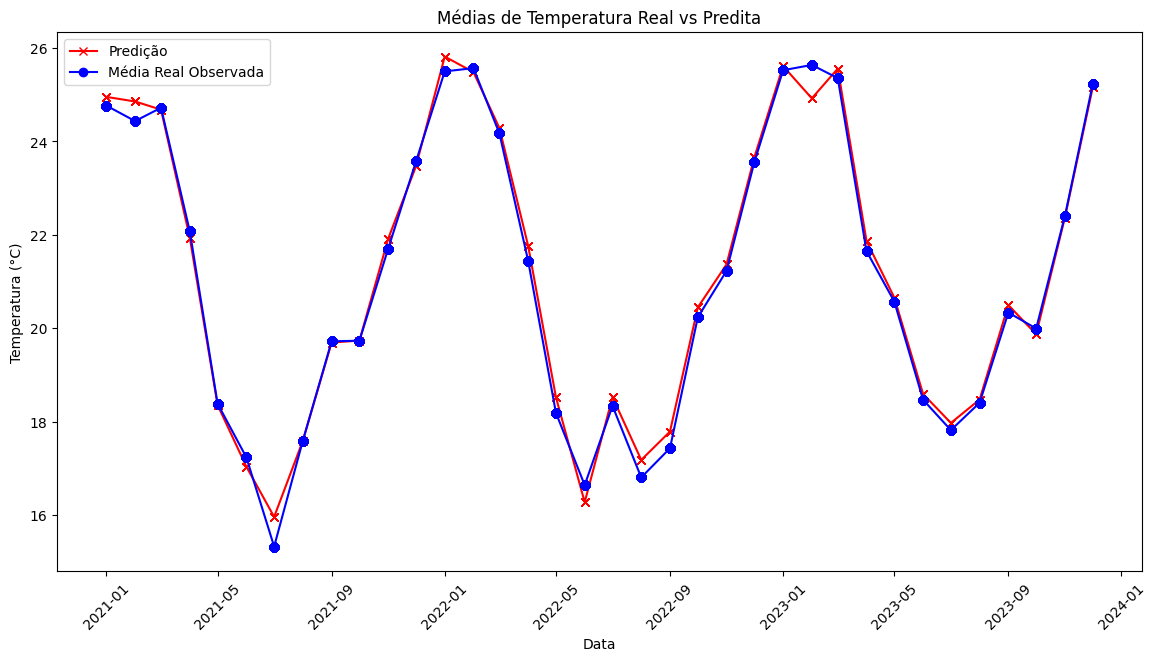

In [ ]:
# Criando um DataFrame para facilitar a visualização
results_df = pd.DataFrame({'Year': X_test['year'], 'Month': X_test['month'], 'Actual': y_test, 'Predicted': y_pred})

# Criando um DataFrame para facilitar a visualização
results_df = pd.DataFrame({'Year': X_test['year'], 'Month': X_test['month'], 'Actual': y_test, 'Predicted': y_pred})

# Ordenando o DataFrame por ano e mês
results_df = results_df.sort_values(by=['Year', 'Month'])

# Combinando ano e mês para formar a data
results_df['Date'] = pd.to_datetime(results_df['Year'].astype(str) + '-' + results_df['Month'].astype(str), format='%Y-%m')

# Calculate the monthly mean of actual temperatures
monthly_means = results_df.groupby('Date')['Actual'].mean()

# Add a new column to the results_df with the monthly mean of actual temperatures
results_df['Monthly Mean Actual'] = results_df['Date'].map(monthly_means)

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the actual and predicted temperatures
#plt.plot(results_df['Date'], results_df['Actual'], label='Actual', color='blue', marker='o', alpha=0.01)
plt.plot(results_df['Date'], results_df['Predicted'], label='Predição', color='red', marker='x')

# Plot the monthly mean of actual temperatures
plt.plot(results_df['Date'], results_df['Monthly Mean Actual'], label='Média Real Observada', color='blue', marker='o')

plt.title('Médias de Temperatura Real vs Predita')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlapping
plt.show()

# V2 - Granularidade Mensal
Dados de 2021 a 2023

In [ ]:
# Agrupar os dados por mês
grouped_df = inmet_df.groupby(['year', 'month'])['mean_temp'].agg(['mean'])

# Exibir o DataFrame agrupado
print(grouped_df)

                 mean
year month           
2021 1      24.905040
     2      24.759673
     3      24.690927
     4      21.979653
     5      18.358333
     6      17.081058
     7      15.830582
     8      17.605847
     9      19.699583
     10     19.743347
     11     21.862014
     12     23.491263
2022 1      25.748387
     2      25.512426
     3      24.250336
     4      21.711042
     5      18.454032
     6      16.343125
     7      18.483580
     8      17.084745
     9      17.708971
     10     20.406519
     11     21.340764
     12     23.647897
2023 1      25.582527
     2      25.077009
     3      25.505309
     4      21.814514
     5      20.651144
     6      18.566134
     7      17.945766
     8      18.462803
     9      20.471019
     10     19.896304
     11     22.364514
     12     25.163105


Criando Modelo

In [ ]:
# Criando o novo conjunto de dados com as médias mensais
X_new = grouped_df.reset_index()[['year', 'month']]
y_new = grouped_df['mean']

# Dividindo os dados em conjuntos de treinamento e teste
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Configurando o modelo de regressão com florestas aleatórias
model_new = RandomForestRegressor(n_estimators=100, random_state=42)
model_new.fit(X_train_new, y_train_new)

# Fazendo previsões
y_pred_new = model_new.predict(X_test_new)

Validação

In [ ]:
# Calcular o RMSE para o novo modelo
rmse_new = mean_squared_error(y_test_new, y_pred_new, squared=False)

# Calcular o MAE para o novo modelo
mae_new = mean_absolute_error(y_test_new, y_pred_new)

# Calcular o R² para o novo modelo
r2_new = r2_score(y_test_new, y_pred_new)

# Imprimir os resultados para o novo modelo
print("RMSE (novo modelo):", rmse_new)
print("MAE (novo modelo):", mae_new)
print("R² (novo modelo):", r2_new)

RMSE (novo modelo): 1.0890767605459986
MAE (novo modelo): 0.973959639531996
R² (novo modelo): 0.8974882234400399


In [ ]:
combined_df = pd.DataFrame({
    'y_pred_new': y_pred_new,
    'y_test_new': y_test_new
})

print(combined_df.head())


            y_pred_new  y_test_new
year month                        
2023 12      23.363878   25.163105
2022 2       24.644722   25.512426
2023 3       24.742669   25.505309
     7       18.708843   17.945766
2022 5       18.823128   18.454032


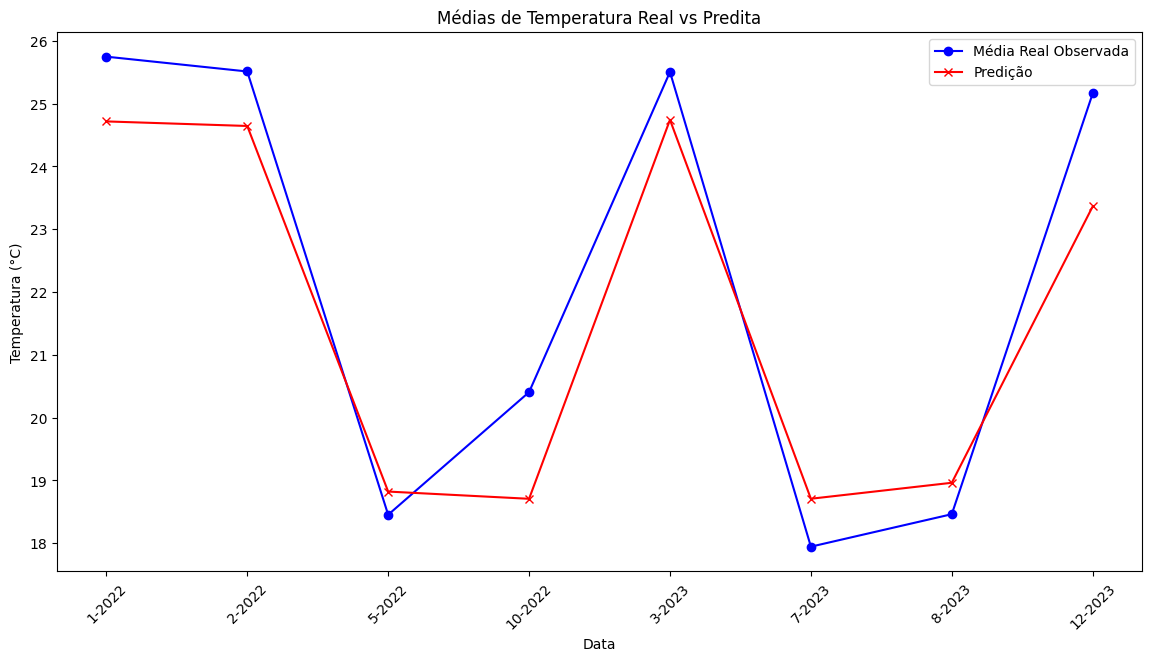

In [ ]:
# Reset the index to convert the multi-index into columns
combined_df = combined_df.reset_index()

# Combine 'month' and 'year' into a single string column
combined_df['month_year'] = combined_df['month'].astype(str) + '-' + combined_df['year'].astype(str)

# Sort the DataFrame by 'year' and 'month'
combined_df = combined_df.sort_values(by=['year', 'month'])

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the actual and predicted temperatures
plt.plot(combined_df['month_year'], combined_df['y_test_new'], label='Média Real Observada', color='blue', marker='o', alpha=1)
plt.plot(combined_df['month_year'], combined_df['y_pred_new'], label='Predição', color='red', marker='x')

plt.title('Médias de Temperatura Real vs Predita')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlapping
plt.show()


# CROSS VALIDATION

In [ ]:
inmet_df_2024 = pd.read_csv('/content/drive/MyDrive/TCC 2024/INMET_S_SC_A806_FLORIANOPOLIS_01-01-2024_A_31-05-2024.CSV', encoding='latin1', delimiter=';', skiprows=8)

In [ ]:
inmet_df_2024 = transformar_dados_climaticos(inmet_df_2024)

In [ ]:
inmet_df_2024.describe()

,date,hour,max_temp,min_temp,year,month,day,mean_temp
count,3648,3648.000000,2175.000000,2175.000000,3648.0,3648.000000,3648.000000,2175.000000
mean,2024-03-16 12:00:00,11.500000,26.061931,25.121333,2024.0,3.006579,15.710526,25.591632
min,2024-01-01 00:00:00,0.000000,16.200000,13.900000,2024.0,1.000000,1.000000,15.350000
25%,2024-02-07 18:00:00,5.750000,24.100000,23.200000,2024.0,2.000000,8.000000,23.650000
50%,2024-03-16 12:00:00,11.500000,26.000000,25.200000,2024.0,3.000000,16.000000,25.600000
75%,2024-04-23 06:00:00,17.250000,28.100000,27.100000,2024.0,4.000000,23.000000,27.600000
max,2024-05-31 00:00:00,23.000000,35.100000,33.500000,2024.0,5.000000,31.000000,34.000000
std,NaN,6.923136,3.027563,2.862614,0.0,1.421354,8.790127,2.928814


In [ ]:
# Contar o número de entradas NaN
nan_count = inmet_df_2024.isnull().sum()

# Selecionar linhas com NaN
nan_rows = inmet_df_2024[inmet_df_2024.isnull().any(axis=1)]

# Exibir resultados
print("Número de entradas NaN:")
print(nan_count)

print("\nLinhas com NaN:")
print(nan_rows)

Número de entradas NaN:
date            0
hour            0
max_temp     1473
min_temp     1473
year            0
month           0
day             0
mean_temp    1473
dtype: int64

Linhas com NaN:
           date  hour  max_temp  min_temp  year  month  day  mean_temp
1084 2024-02-15     4       NaN       NaN  2024      2   15        NaN
1085 2024-02-15     5       NaN       NaN  2024      2   15        NaN
1086 2024-02-15     6       NaN       NaN  2024      2   15        NaN
1087 2024-02-15     7       NaN       NaN  2024      2   15        NaN
1088 2024-02-15     8       NaN       NaN  2024      2   15        NaN
...         ...   ...       ...       ...   ...    ...  ...        ...
3637 2024-05-31    13       NaN       NaN  2024      5   31        NaN
3638 2024-05-31    14       NaN       NaN  2024      5   31        NaN
3645 2024-05-31    21       NaN       NaN  2024      5   31        NaN
3646 2024-05-31    22       NaN       NaN  2024      5   31        NaN
3647 2024-05-31    23

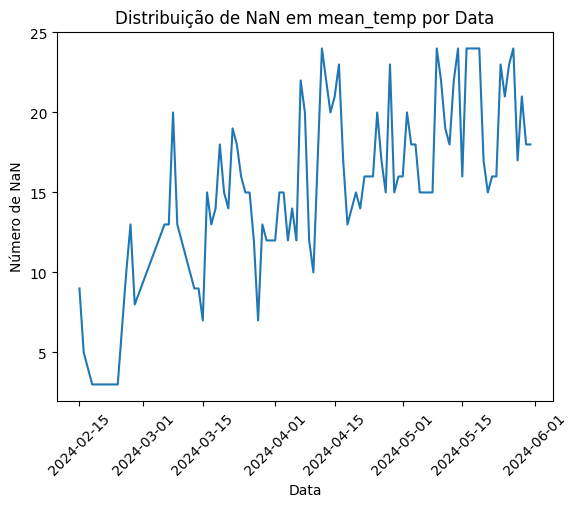

In [ ]:
# prompt: gere um gráfco com a distribuição de mean_temp NaN para o inmet_df_2024 por date

import seaborn as sns

# Selecionar linhas com NaN em mean_temp
nan_temp_rows = inmet_df_2024[inmet_df_2024['mean_temp'].isnull()]

# Agrupar por data e contar o número de linhas com NaN
nan_temp_count_by_date = nan_temp_rows.groupby('date').size().reset_index(name='count')

# Plot the distribution of NaN values for mean_temp by date
sns.lineplot(data=nan_temp_count_by_date, x='date', y='count')
plt.title('Distribuição de NaN em mean_temp por Data')
plt.xlabel('Data')
plt.ylabel('Número de NaN')
plt.xticks(rotation=45)
plt.show()


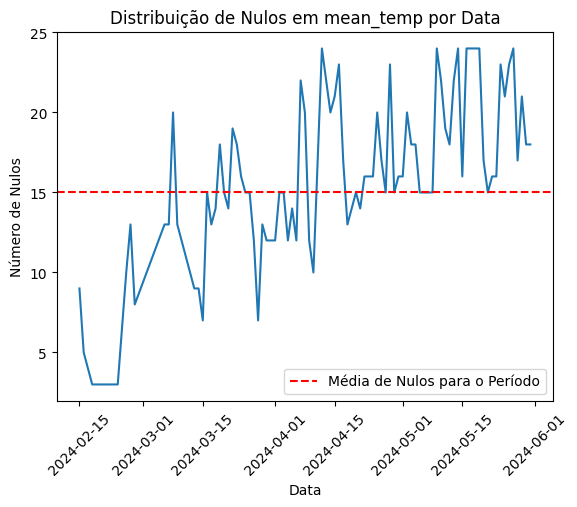

In [ ]:
# prompt: recrei o gráfico acima adicionando uma linha com a média de valores NaN

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean of the 'count' column
mean_nan_count = int(nan_temp_count_by_date['count'].mean())

# Plot the distribution of NaN values for mean_temp by date
sns.lineplot(data=nan_temp_count_by_date, x='date', y='count')

# Add a horizontal line for the mean
plt.axhline(y=mean_nan_count, color='red', linestyle='dashed', label='Média de Nulos para o Período')

plt.title('Distribuição de Nulos em mean_temp por Data')
plt.xlabel('Data')
plt.ylabel('Número de Nulos')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
inmet_df_2024 = inmet_df_2024.dropna(subset=['mean_temp'])

In [ ]:
inmet_df_2024.describe()

,date,hour,max_temp,min_temp,year,month,day,mean_temp
count,2175,2175.000000,2175.000000,2175.000000,2175.0,2175.000000,2175.000000,2175.000000
mean,2024-02-21 22:08:06.620689664,12.791264,26.061931,25.121333,2024.0,2.256552,14.766437,25.591632
min,2024-01-01 00:00:00,0.000000,16.200000,13.900000,2024.0,1.000000,1.000000,15.350000
25%,2024-01-23 00:00:00,7.000000,24.100000,23.200000,2024.0,1.000000,7.000000,23.650000
50%,2024-02-15 00:00:00,14.000000,26.000000,25.200000,2024.0,2.000000,14.000000,25.600000
75%,2024-03-14 00:00:00,18.000000,28.100000,27.100000,2024.0,3.000000,22.000000,27.600000
max,2024-05-31 00:00:00,23.000000,35.100000,33.500000,2024.0,5.000000,31.000000,34.000000
std,NaN,6.686062,3.027563,2.862614,0.0,1.213017,8.927268,2.928814


In [ ]:
# Agrupar os dados por mês
grouped_df_2024 = inmet_df_2024.groupby(['year', 'month'])['mean_temp'].agg(['mean'])

# Exibir o DataFrame agrupado
print(grouped_df_2024)

                 mean
year month           
2024 1      24.613239
     2      26.686299
     3      26.374769
     4      25.534234
     5      23.529930


In [ ]:
# prompt: utilize grouped_df_2024 como teste para ambos os modelos e compare seus resultados

# V1 - Granularidade Horária
# Dados de 2024
X_test_2024 = grouped_df_2024.reset_index()[['year', 'month']]
y_test_2024 = grouped_df_2024['mean']

# Fazendo previsões
y_pred_2024 = model.predict(X_test_2024)

# Calculate the RMSE for the V1 model
rmse_2024_v1 = mean_squared_error(y_test_2024, y_pred_2024, squared=False)

# Calculate the MAE for the V1 model
mae_2024_v1 = mean_absolute_error(y_test_2024, y_pred_2024)

# Calculate the R² for the V1 model
r2_2024_v1 = r2_score(y_test_2024, y_pred_2024)

# Print the results for the V1 model
print("V1 - Granularidade Horária")
print("RMSE:", rmse_2024_v1)
print("MAE:", mae_2024_v1)
print("R²:", r2_2024_v1)

# V2 - Granularidade Mensal
# Dados de 2024
X_test_new_2024 = grouped_df_2024.reset_index()[['year', 'month']]
y_test_new_2024 = grouped_df_2024['mean']

# Fazendo previsões
y_pred_new_2024 = model_new.predict(X_test_new_2024)

# Calculate the RMSE for the V2 model
rmse_2024_v2 = mean_squared_error(y_test_new_2024, y_pred_new_2024, squared=False)

# Calculate the MAE for the V2 model
mae_2024_v2 = mean_absolute_error(y_test_new_2024, y_pred_new_2024)

# Calculate the R² for the V2 model
r2_2024_v2 = r2_score(y_test_new_2024, y_pred_new_2024)

# Print the results for the V2 model
print("\nV2 - Granularidade Mensal")
print("RMSE:", rmse_2024_v2)
print("MAE:", mae_2024_v2)
print("R²:", r2_2024_v2)


V1 - Granularidade Horária
RMSE: 2.302453195150075
MAE: 2.02526295777448
R²: -2.941342640031184

V2 - Granularidade Mensal
RMSE: 2.4754629199681215
MAE: 2.1911761157137257
R²: -3.5559129942533465


In [ ]:
# prompt: gere um dataframe contendo os valores predicted dos dois modelos e os valores reais

results_df = pd.DataFrame({'V1_Predicted': y_pred_2024, 'V2_Predicted': y_pred_new_2024, 'Actual': y_test_2024})

print(results_df.head())


            V1_Predicted  V2_Predicted     Actual
year month                                       
2024 1         25.611123     25.293881  24.613239
     2         24.919712     25.092472  26.686299
     3         25.555807     24.742669  26.374769
     4         21.866247     21.758702  25.534234
     5         20.655035     20.256150  23.529930


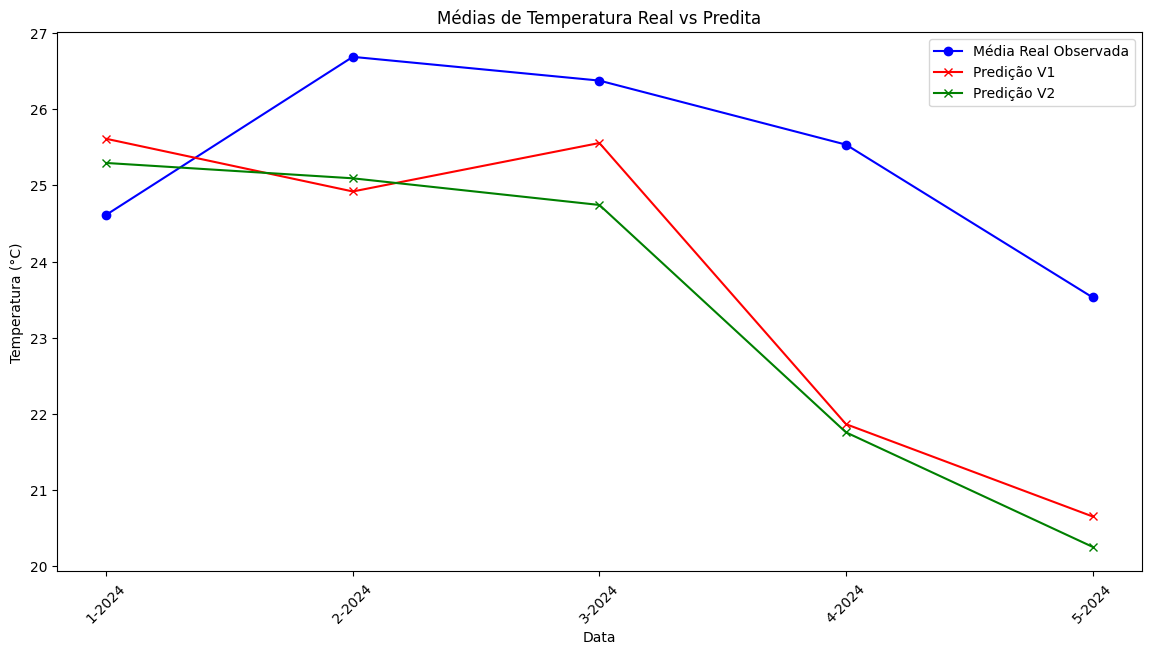

In [ ]:
import matplotlib.pyplot as plt

# Supondo que 'results_df' seja o DataFrame inicial com um índice multi-nível de 'year' e 'month'

# Reset the index to convert the multi-index into columns
results_df = results_df.reset_index()

# Combine 'month' and 'year' into a single string column
results_df['month_year'] = results_df['month'].astype(str) + '-' + results_df['year'].astype(str)

# Sort the DataFrame by 'year' and 'month'
results_df = results_df.sort_values(by=['year', 'month'])

# Verificar se as colunas contêm apenas valores numéricos
results_df['Actual'] = results_df['Actual'].astype(float)
results_df['V1_Predicted'] = results_df['V1_Predicted'].astype(float)
results_df['V2_Predicted'] = results_df['V2_Predicted'].astype(float)

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the actual and predicted temperatures
plt.plot(results_df['month_year'], results_df['Actual'], label='Média Real Observada', color='blue', marker='o', alpha=1)
plt.plot(results_df['month_year'], results_df['V1_Predicted'], label='Predição V1', color='red', marker='x')
plt.plot(results_df['month_year'], results_df['V2_Predicted'], label='Predição V2', color='green', marker='x')

plt.title('Médias de Temperatura Real vs Predita')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlapping
plt.show()


In [ ]:
# prompt: filter combined_df to have only month and year greater than june 2023

grouped_df.reset_index(inplace=True)

filtered_df = grouped_df[
    (grouped_df['month'] >= 4) & (grouped_df['year'] == 2023)
]


In [ ]:
filtered_df

,year,month,mean
27,2023,4,21.814514
28,2023,5,20.651144
29,2023,6,18.566134
30,2023,7,17.945766
31,2023,8,18.462803
32,2023,9,20.471019
33,2023,10,19.896304
34,2023,11,22.364514
35,2023,12,25.163105


In [ ]:
# prompt: concat filtered_df and results_df (mean and Actual are the same column)

combined_df = pd.concat([filtered_df, results_df], axis=1)
combined_df


,year,month,mean,year,month,V1_Predicted,V2_Predicted,Actual,month_year
27,2023.0,4.0,21.814514,NaN,NaN,NaN,NaN,NaN,NaN
28,2023.0,5.0,20.651144,NaN,NaN,NaN,NaN,NaN,NaN
29,2023.0,6.0,18.566134,NaN,NaN,NaN,NaN,NaN,NaN
30,2023.0,7.0,17.945766,NaN,NaN,NaN,NaN,NaN,NaN
31,2023.0,8.0,18.462803,NaN,NaN,NaN,NaN,NaN,NaN
32,2023.0,9.0,20.471019,NaN,NaN,NaN,NaN,NaN,NaN
33,2023.0,10.0,19.896304,NaN,NaN,NaN,NaN,NaN,NaN
34,2023.0,11.0,22.364514,NaN,NaN,NaN,NaN,NaN,NaN
35,2023.0,12.0,25.163105,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,2024.0,1.0,25.611123,25.293881,24.613239,1-2024


In [ ]:
results_df.head()

,year,month,V1_Predicted,V2_Predicted,Actual,month_year
0,2024,1,25.611123,25.293881,24.613239,1-2024
1,2024,2,24.919712,25.092472,26.686299,2-2024
2,2024,3,25.555807,24.742669,26.374769,3-2024
3,2024,4,21.866247,21.758702,25.534234,4-2024
4,2024,5,20.655035,20.256150,23.529930,5-2024


<ipython-input-33-6f4bba39fa51>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={'mean': 'Actual'}, inplace=True)
<ipython-input-33-6f4bba39fa51>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['V1_Predicted'] = None
<ipython-input-33-6f4bba39fa51>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

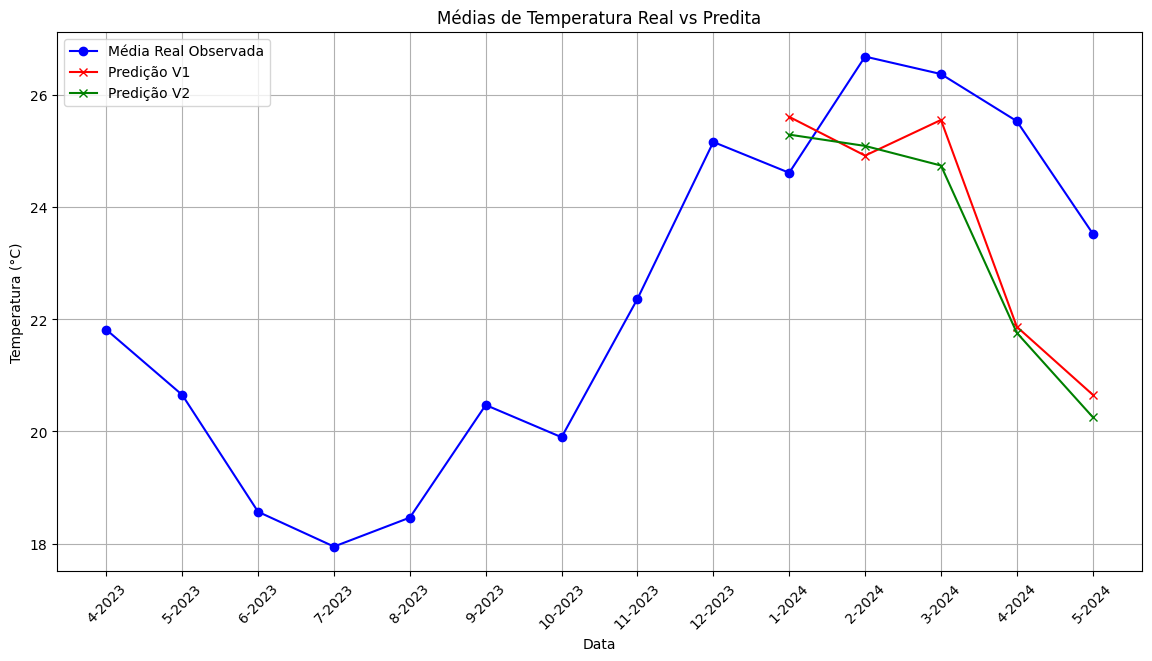

In [ ]:

# Renomear a coluna 'mean' para 'Actual'
filtered_df.rename(columns={'mean': 'Actual'}, inplace=True)

# Adicionar colunas 'V1_Predicted' e 'V2_Predicted' com valores nulos
filtered_df['V1_Predicted'] = None
filtered_df['V2_Predicted'] = None

# Criar a coluna 'month_year'
filtered_df['month_year'] = filtered_df['month'].astype(str) + '-' + filtered_df['year'].astype(str)

# Combinar os DataFrames
combined_df_2 = pd.concat([filtered_df, results_df], ignore_index=True)

# Ordenar o DataFrame pelo ano e mês
combined_df_2 = combined_df_2.sort_values(by=['year', 'month'])

# Verificar se as colunas contêm apenas valores numéricos
combined_df_2['Actual'] = combined_df_2['Actual'].astype(float)
combined_df_2['V1_Predicted'] = combined_df_2['V1_Predicted'].astype(float)
combined_df_2['V2_Predicted'] = combined_df_2['V2_Predicted'].astype(float)

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the actual and predicted temperatures
plt.plot(combined_df_2['month_year'], combined_df_2['Actual'], label='Média Real Observada', color='blue', marker='o', alpha=1)
plt.plot(combined_df_2['month_year'], combined_df_2['V1_Predicted'], label='Predição V1', color='red', marker='x')
plt.plot(combined_df_2['month_year'], combined_df_2['V2_Predicted'], label='Predição V2', color='green', marker='x')

plt.title('Médias de Temperatura Real vs Predita')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlapping
plt.grid(True)
plt.show()

In [ ]:
model_new.predict([['2024', '6'],['2024', '7']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([18.77603236, 18.70884308])